In [1]:
import csv
import cv2
import itertools
import numpy as np
import pandas as pd
import os
import sys
import tempfile
import tqdm

from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [178]:
from scipy.io import loadmat
digittest_dataset = loadmat('digit/digittest_dataset.mat')
digittrain_dataset = loadmat('digit/digittrain_dataset.mat')

In [206]:
# Extract the image data
XTestImages = digittest_dataset['xTestImages']

train_images = digittrain_dataset['xTrainImages']  # Extracting the array
test_images = digittest_dataset['xTestImages']     # Extracting the array

# Iterate over the arrays
XTrainImages = np.array([train_images[0, i] for i in range(train_images.shape[1])])
XTestImages = np.array([test_images[0, i] for i in range(test_images.shape[1])])

# Reshape the images for the autoencoder
XTrainImages = XTrainImages.reshape((-1, 28, 28, 1))
XTestImages = XTestImages.reshape((-1, 28, 28, 1))

yTest = np.argmax(digittest_dataset['tTest'], axis=0)  # Convert one-hot to single digit labels
yTest = (yTest + 1) % 10 

yTrain = np.argmax(digittrain_dataset['tTrain'], axis=0)  # Convert one-hot to single digit labels
yTrain = (yTrain + 1) % 10

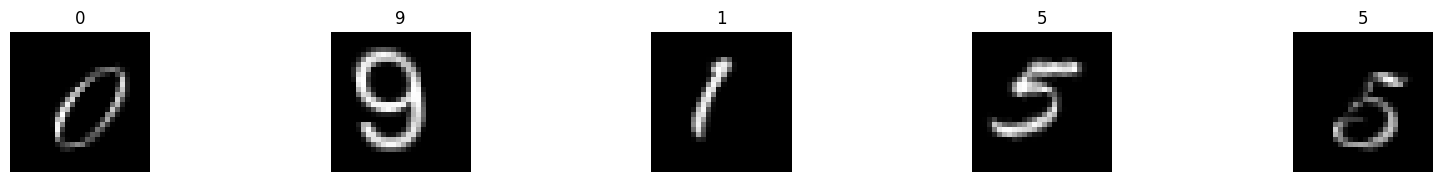

In [197]:
import matplotlib.pyplot as plt

n = 5
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(XTestImages[i].reshape(28, 28), cmap='gray')
    plt.title(yTest[i])
    plt.axis('off')
plt.show()

In [207]:

# Define the autoencoder
input_img = tf.keras.Input(shape=(28, 28, 1))

# Encoder
x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)

# Decoder
x = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
decoded = tf.keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder1 = tf.keras.Model(input_img, decoded)

autoencoder1.compile(optimizer='adam', loss='binary_crossentropy')

# Assuming XTrainImages and XTestImages are already loaded and reshaped
autoencoder1.fit(XTrainImages, XTrainImages, epochs=50, batch_size=256, shuffle=True, validation_data=(XTestImages, XTestImages))


Epoch 1/50
20/20 [==============================] - 2s 72ms/step - loss: 0.6598 - val_loss: 0.5596
Epoch 2/50
20/20 [==============================] - 1s 48ms/step - loss: 0.4808 - val_loss: 0.3981
Epoch 3/50
20/20 [==============================] - 1s 46ms/step - loss: 0.3401 - val_loss: 0.2427
Epoch 4/50
20/20 [==============================] - 1s 46ms/step - loss: 0.2300 - val_loss: 0.1768
Epoch 5/50
20/20 [==============================] - 1s 45ms/step - loss: 0.2063 - val_loss: 0.1625
Epoch 6/50
20/20 [==============================] - 1s 46ms/step - loss: 0.1947 - val_loss: 0.1518
Epoch 7/50
20/20 [==============================] - 1s 48ms/step - loss: 0.1871 - val_loss: 0.1455
Epoch 8/50
20/20 [==============================] - 1s 46ms/step - loss: 0.1811 - val_loss: 0.1390
Epoch 9/50
20/20 [==============================] - 1s 44ms/step - loss: 0.1749 - val_loss: 0.1336
Epoch 10/50
20/20 [==============================] - 1s 45ms/step - loss: 0.1704 - val_loss: 0.1301
Epoch 11/

In [209]:
# Save result for the second autoencoder
encoded_decoded_train_images = autoencoder1.predict(XTrainImages)
# Decode some images
encoded_decoded_test_images = autoencoder1.predict(XTestImages)
# Print the shape of the encoded output
print("Shape of encoded output:", encoded_decoded_test_images.shape)

157/157 [==============================] - 1s 4ms/step
Shape of encoded output: (5000, 28, 28, 1)


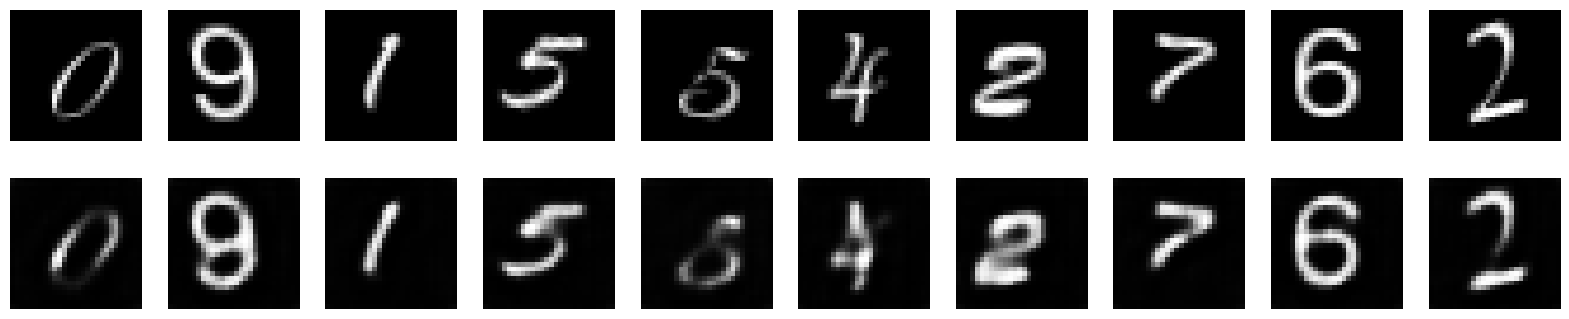

In [210]:
# # Visualize the original and reconstructed images
n = 10  # number of images to display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(XTestImages[i].reshape(28, 28), cmap='gray')
    plt.axis('off')

    # display reconstruction
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(encoded_decoded_test_images[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
plt.show()

In [211]:
# Define the second autoencoder
encoded_input = tf.keras.Input(shape=(28, 28, 1))  # Shape to match the output of the first encoder

# Second autoencoder's encoder
x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(encoded_input)
x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded2 = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)

# Second autoencoder's decoder
x = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded2)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
decoded2 = tf.keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder2 = tf.keras.Model(encoded_input, decoded2)

autoencoder2.compile(optimizer='adam', loss='binary_crossentropy')

# Train the second autoencoder
# Here, encoded_decoded_train_images and encoded_decoded_test_images should be the output of the first autoencoder
autoencoder2.fit(encoded_decoded_train_images, encoded_decoded_train_images, epochs=50, batch_size=256, shuffle=True, validation_data=(encoded_decoded_test_images, encoded_decoded_test_images))

Epoch 1/50
20/20 [==============================] - 2s 74ms/step - loss: 0.6470 - val_loss: 0.5383
Epoch 2/50
20/20 [==============================] - 1s 52ms/step - loss: 0.4707 - val_loss: 0.3783
Epoch 3/50
20/20 [==============================] - 1s 48ms/step - loss: 0.3067 - val_loss: 0.2391
Epoch 4/50
20/20 [==============================] - 1s 45ms/step - loss: 0.2300 - val_loss: 0.2109
Epoch 5/50
20/20 [==============================] - 1s 46ms/step - loss: 0.2112 - val_loss: 0.1948
Epoch 6/50
20/20 [==============================] - 1s 45ms/step - loss: 0.1955 - val_loss: 0.1821
Epoch 7/50
20/20 [==============================] - 1s 45ms/step - loss: 0.1857 - val_loss: 0.1748
Epoch 8/50
20/20 [==============================] - 1s 44ms/step - loss: 0.1787 - val_loss: 0.1686
Epoch 9/50
20/20 [==============================] - 1s 44ms/step - loss: 0.1728 - val_loss: 0.1632
Epoch 10/50
20/20 [==============================] - 1s 44ms/step - loss: 0.1677 - val_loss: 0.1587
Epoch 11/

157/157 [==============================] - 1s 6ms/step - loss: 0.1418
Test Loss: 0.14183755218982697
157/157 [==============================] - 1s 4ms/step


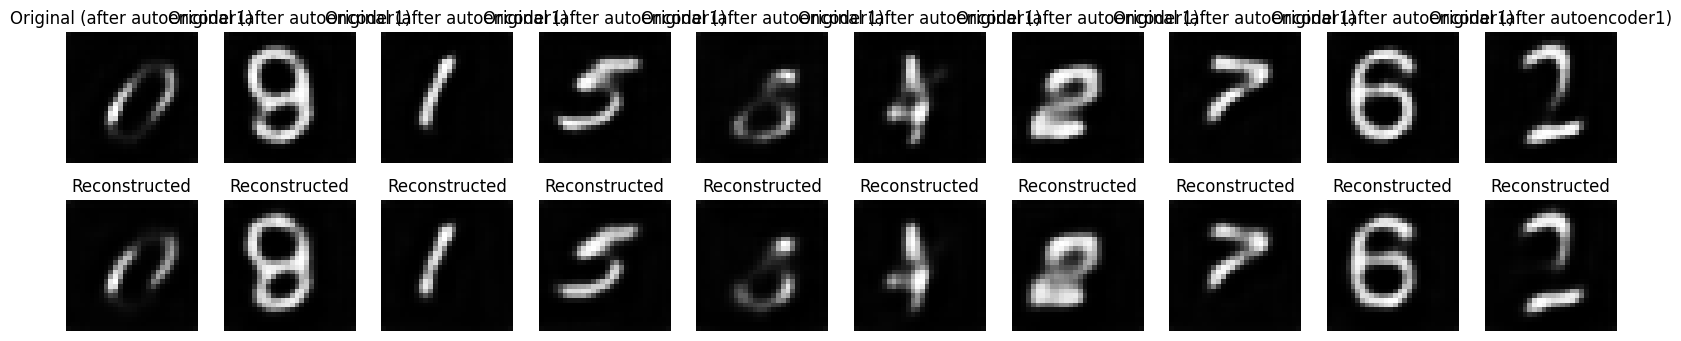

In [212]:
# Evaluate the autoencoder on the encoded test data
test_loss = autoencoder2.evaluate(encoded_decoded_test_images, encoded_decoded_test_images)
print('Test Loss:', test_loss)

# Predict (reconstruct) the test images
reconstructed_test_images = autoencoder2.predict(encoded_decoded_test_images)

# Visualize the original and reconstructed images
n = 10  # Number of images to display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(encoded_decoded_test_images[i].reshape(28, 28), cmap='gray')
    plt.title("Original (after autoencoder1)")
    plt.axis('off')

    # Display reconstruction
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(reconstructed_test_images[i].reshape(28, 28), cmap='gray')
    plt.title("Reconstructed")
    plt.axis('off')

plt.show()

In [213]:
# Extract encoded features for the training and test sets
encoded_decoded_2_train_images = autoencoder2.predict(encoded_decoded_train_images)
encoded_decoded_2_test_images = autoencoder2.predict(encoded_decoded_test_images)

# Define a softmax classifier
classifier_input = tf.keras.Input(shape=(28, 28, 1))
x = tf.keras.layers.Flatten()(classifier_input)
x = tf.keras.layers.Dense(64, activation='relu')(x)
output = tf.keras.layers.Dense(10, activation='softmax')(x)  # 10 classes for digits 0-9

classifier = tf.keras.Model(classifier_input, output)

classifier.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the classifier
history = classifier.fit(encoded_decoded_2_train_images, yTrain, epochs=50, batch_size=256, validation_data=(encoded_decoded_2_test_images, yTest))

157/157 [==============================] - 1s 4ms/step
Epoch 1/50
20/20 [==============================] - 1s 19ms/step - loss: 1.9491 - accuracy: 0.3886 - val_loss: 1.6138 - val_accuracy: 0.5666
Epoch 2/50
20/20 [==============================] - 0s 10ms/step - loss: 1.3957 - accuracy: 0.6340 - val_loss: 1.2241 - val_accuracy: 0.6752
Epoch 3/50
20/20 [==============================] - 0s 9ms/step - loss: 1.0864 - accuracy: 0.7164 - val_loss: 1.0056 - val_accuracy: 0.7230
Epoch 4/50
20/20 [==============================] - 0s 8ms/step - loss: 0.9098 - accuracy: 0.7482 - val_loss: 0.8742 - val_accuracy: 0.7454
Epoch 5/50
20/20 [==============================] - 0s 8ms/step - loss: 0.7964 - accuracy: 0.7726 - val_loss: 0.7865 - val_accuracy: 0.7658
Epoch 6/50
20/20 [==============================] - 0s 9ms/step - loss: 0.7198 - accuracy: 0.7858 - val_loss: 0.7207 - val_accuracy: 0.7800
Epoch 7/50
20/20 [==============================] - 0s 8ms/step - loss: 0.6610 - accuracy: 0.7956 - val

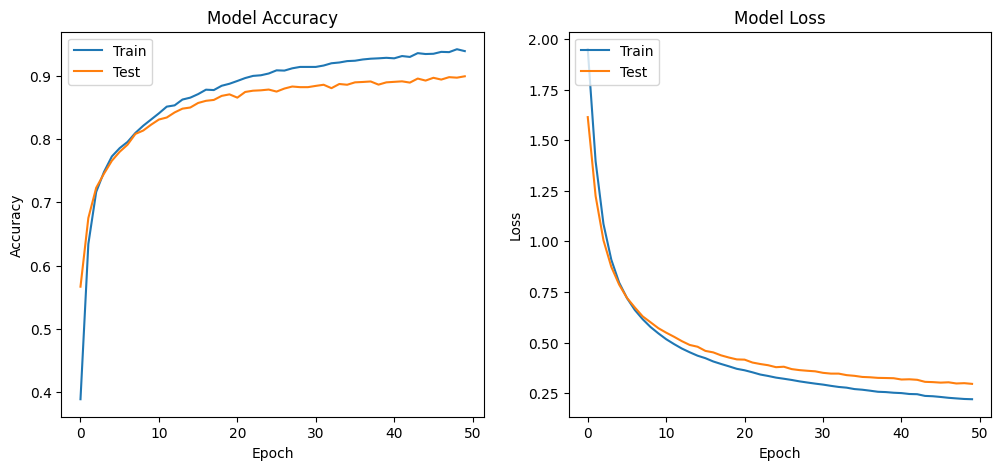

In [214]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()


157/157 [==============================] - 0s 1ms/step


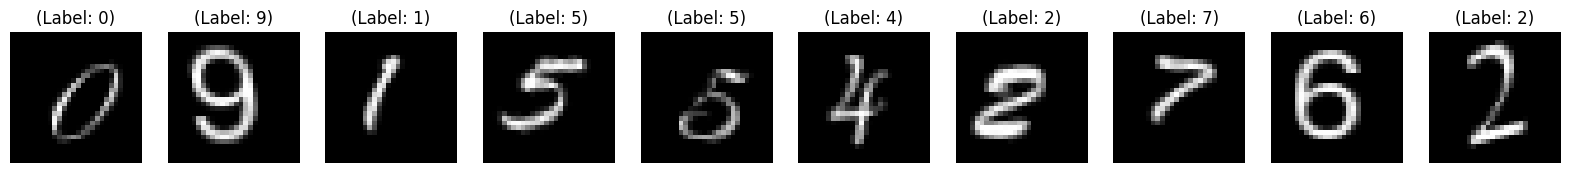

In [215]:
# Predict (reconstruct) the test images
classifier_test_images = classifier.predict(encoded_decoded_2_test_images)
# np.argmax(classifier_test_images[2])

n = 10  # Number of images to display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(XTestImages[i].reshape(28, 28), cmap='gray')
    plt.title(f"(Label: {yTest[i]})")
    plt.axis('off')

